# Link Analysis 1

In [ ]:
import sys
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

sys.path.insert(
    0, "/Users/user/Documents/htx_xdata/htx_xdata_tech_interview"
)

from src.preprocess import preprocess_pipeline


## Load data

In [64]:
print("\n" + "=" * 80)
print('Load Data and clean data')
print("=" * 80 + "\n")
# Data path
registration_date_jan_2017_path = r'/Users/user/Documents/htx_xdata/htx_xdata_tech_interview/data/HDB/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv'

# Load data into pandas dataframe
registration_date_jan_2017_df = pd.read_csv(registration_date_jan_2017_path)

# Preprocess the data
registration_date_jan_2017_df_cleaned = preprocess_pipeline(registration_date_jan_2017_df)


Load Data and clean data

Duplicates :210
After dropping Duplicates :0
Column : resale_price datatype before converting : float64
Column : resale_price datatype after converting : int64
Column : floor_area_sqm datatype before converting : float64
Column : floor_area_sqm datatype after converting : int64
Column : remaining_lease datatype before converting : object
Column : remaining_lease datatype after converting : int64
-----------------------------------


In [59]:
print("\n" + "=" * 80)
print('Column in the cleaned Dataframe')
print("=" * 80 + "\n")

registration_date_jan_2017_df_cleaned.columns


Column in the cleaned Dataframe



Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'month_only', 'year_only',
       'floor_area_sqft', 'storey_min', 'storey_max', 'psf_temp', 'psf',
       'address', 'road'],
      dtype='object')

In [60]:
def construct_property_graph(df, year_threshold=2017):
    print("\n" + "=" * 80)
    print("LINK ANALYSIS TASK I: PROPERTY GRAPH CONSTRUCTION")
    print("=" * 80 + "\n")
    
    # Filter data for Jan 2017 onwards
    df_filtered = df[df["year_only"] >= year_threshold].copy()
    print(
        f"Filtered data: {len(df_filtered):,} transactions from {year_threshold} onwards"
    )
    
    # Sample data for computational efficiency (use full dataset for production)
    # Using stratified sampling to maintain distribution
    sample_size = min(2000, len(df_filtered))
    df_sample = df_filtered.sample(n=sample_size, random_state=42)
    print(f"Using sample of {sample_size:,} transactions for graph analysis")
    
    # Reset index to use as node IDs
    df_sample = df_sample.reset_index(drop=True)

    # Create graph
    G = nx.Graph()
    
     # Add nodes with attributes
    print("\nAdding nodes to graph...")
    for idx, row in df_sample.iterrows():
        G.add_node(
            idx,# Node number
            address=row["address"], # Node properties
            town=row["town"],
            road=row["road"],
            flat_type=row["flat_type"],
            sqft=row["floor_area_sqft"],
            lease_remaining=row["remaining_lease"],
            price=row["resale_price"],
            psf=row["psf"],
            year_of_sale=row["year_only"],
            month_of_sale=row["month_only"],
            minimum_floor=row["storey_min"],
        )
    print(f"Added {G.number_of_nodes():,} nodes")
    
    # Add edges based on similarity criteria (optimized approach)
    print("\nAdding edges based on similarity criteria...")
    edge_types = []
    edges_added = 0
    
    # Group by town and flat_type for efficient edge creation
    for (town, flat_type), group_df in df_sample.groupby(["town", "flat_type"]):
        group_indices = group_df.index.tolist()

        # Connect properties within the same town and flat type
        for i_idx, i in enumerate(group_indices):
            for j in group_indices[i_idx + 1 :]:
                edge_weight = 3  # Already same town (1) + same flat_type (2)
                edge_reasons = ["same_town", "same_flat_type"]

                # Same road (weight: 3)
                if df_sample.loc[i, "road"] == df_sample.loc[j, "road"]:
                    edge_weight += 3
                    edge_reasons.append("same_road")

                # Similar lease remaining (within 5 years, weight: 1)
                lease_diff = abs(
                    df_sample.loc[i, "remaining_lease"]
                    - df_sample.loc[j, "remaining_lease"]
                )
                if lease_diff <= 5:
                    edge_weight += 1
                    edge_reasons.append("similar_lease")
                    

                # Add edge (already meets minimum weight of 3)
                G.add_edge(i, j, weight=edge_weight, reasons=edge_reasons)
                edge_types.extend(edge_reasons)
                edges_added += 1

                if edges_added % 10000 == 0:
                    print(f"  Added {edges_added:,} edges...")

    print(f"\nAdded {G.number_of_edges():,} edges")

    # Analyze edge type distribution
    edge_type_counts = Counter(edge_types)
    print("\nEdge Type Distribution:")
    for edge_type, count in edge_type_counts.most_common():
        print(f"  {edge_type}: {count:,}")
        
    # Graph statistics
    print("\n" + "-" * 80)
    print("GRAPH STATISTICS")
    print("-" * 80)
    print(f"Number of nodes: {G.number_of_nodes():,}")
    print(f"Number of edges: {G.number_of_edges():,}")
    print(f"Graph density: {nx.density(G):.6f}")
    print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

    # Connected components analysis
    connected_components = list(nx.connected_components(G))
    print(f"\nNumber of connected components: {len(connected_components)}")

    component_sizes = [len(comp) for comp in connected_components]
    print(
        f"Largest component size: {max(component_sizes):,} nodes ({max(component_sizes)/G.number_of_nodes()*100:.1f}%)"
    )
    print(f"Smallest component size: {min(component_sizes):,} nodes")
    print(f"Average component size: {np.mean(component_sizes):.2f} nodes")

    # Analyze largest component
    largest_component = max(connected_components, key=len)
    G_largest = G.subgraph(largest_component).copy()

    print(f"\nLargest Component Analysis:")
    print(f"  Nodes: {G_largest.number_of_nodes():,}")
    print(f"  Edges: {G_largest.number_of_edges():,}")
    print(f"  Average clustering coefficient: {nx.average_clustering(G_largest):.4f}")
    print(
        f"  Diameter: {nx.diameter(G_largest) if nx.is_connected(G_largest) else 'N/A (disconnected)'}"
    )

    # Visualize component size distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle("Property Graph Analysis", fontsize=14, fontweight="bold")

    # Component size distribution
    ax1 = axes[0]
    component_sizes_sorted = sorted(component_sizes, reverse=True)[:20]
    ax1.bar(
        range(len(component_sizes_sorted)),
        component_sizes_sorted,
        color="steelblue",
        alpha=0.7,
    )
    ax1.set_xlabel("Component Rank")
    ax1.set_ylabel("Component Size (number of nodes)")
    ax1.set_title("Top 20 Connected Components by Size", fontweight="bold")
    ax1.grid(axis="y", alpha=0.3)

    # Degree distribution
    ax2 = axes[1]
    degrees = [deg for node, deg in G.degree()]
    ax2.hist(degrees, bins=50, color="coral", alpha=0.7, edgecolor="black")
    ax2.set_xlabel("Node Degree")
    ax2.set_ylabel("Frequency")
    ax2.set_title("Degree Distribution", fontweight="bold")
    ax2.axvline(
        np.mean(degrees),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {np.mean(degrees):.1f}",
    )
    ax2.legend()
    ax2.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.savefig("graph_construction_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()
    plt.close()

    print(f"\nVisualization saved to: graph_construction_analysis.png")
    
    return G, df_sample



LINK ANALYSIS TASK I: PROPERTY GRAPH CONSTRUCTION

Filtered data: 80,164 transactions from 2017 onwards
Using sample of 2,000 transactions for graph analysis

Adding nodes to graph...
Added 2,000 nodes

Adding edges based on similarity criteria...
  Added 10,000 edges...
  Added 20,000 edges...
  Added 30,000 edges...

Added 34,254 edges

Edge Type Distribution:
  same_town: 34,254
  same_flat_type: 34,254
  similar_lease: 18,262
  same_road: 3,037

--------------------------------------------------------------------------------
GRAPH STATISTICS
--------------------------------------------------------------------------------
Number of nodes: 2,000
Number of edges: 34,254
Graph density: 0.017136
Average degree: 34.25

Number of connected components: 114
Largest component size: 96 nodes (4.8%)
Smallest component size: 1 nodes
Average component size: 17.54 nodes

Largest Component Analysis:
  Nodes: 96
  Edges: 4,560
  Average clustering coefficient: 1.0000
  Diameter: 1


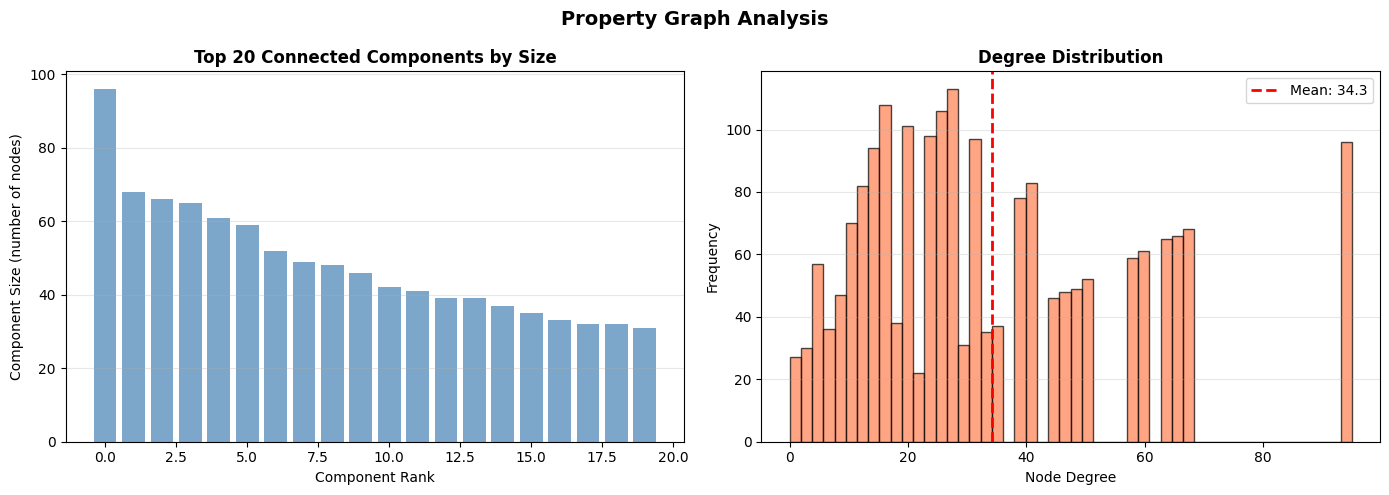


Visualization saved to: graph_construction_analysis.png


In [61]:
G, df_sample = construct_property_graph(registration_date_jan_2017_df_cleaned)

### Observation 

Connected Components (Group of Nodes where every node can reach every other)
- Largest components has about 95 components , indicating a dominant cluster
- The others shown in the graph indicates many smaller independant subgraph.
- More time is needed to look into the largest component.


Degree Distribution (Histogram of node degrees)
- Indicates how many connections each node have
- The mean is about 34.3 connections per node.
- The distribution is wide and skewed. Indicating many have lower number of connections
- A small number of nodes have very high number of connections

# Link Analysis 2

In [62]:
def run_graph_algorithms(G, df_sample):
    """
    Run various graph algorithms on the property graph

    Algorithms:
    1. PageRank: Identify influential properties
    2. Community Detection (Louvain): Find property clusters
    3. Betweenness Centrality: Find bridge properties
    4. Degree Centrality: Find well-connected properties
    """
    print("\n" + "=" * 80)
    print("LINK ANALYSIS TASK II: GRAPH ALGORITHMS")
    print("=" * 80 + "\n")

    # Algorithm 1: PageRank
    print("-" * 80)
    print("ALGORITHM 1: PageRank")
    print("-" * 80)
    print("\nHow it works:")
    print("PageRank is an algorithm originally developed by Google to rank web pages.")
    print("It works by counting the number and quality of connections to a node to")
    print("determine a rough estimate of how 'important' that node is. The algorithm")
    print("assumes that more important nodes are likely to receive more connections.")
    print("\nIn our property graph context:")
    print("- Nodes with high PageRank are properties that are highly connected to")
    print("  other well-connected properties")
    print("- These represent 'typical' or 'benchmark' properties in the market")
    print("- They share many characteristics with other properties")

    pagerank = nx.pagerank(G, weight="weight")
    df_sample["pagerank"] = df_sample.index.map(pagerank)

    print("\nTop 10 Properties by PageRank:")
    top_pagerank = df_sample.nlargest(10, "pagerank")[
        ["address", "town", "flat_type", "resale_price", "psf", "pagerank"]
    ]
    print(top_pagerank.to_string(index=False))

    print("\nInterpretation:")
    print("Properties with high PageRank scores are 'typical' market representatives.")
    print("They share multiple characteristics with many other properties, making them")
    print("good reference points for price comparisons and market analysis.")

    # Algorithm 2: Community Detection
    print("\n" + "-" * 80)
    print("ALGORITHM 2: Community Detection (Greedy Modularity)")
    print("-" * 80)
    print("\nHow it works:")
    print("Community detection algorithms identify groups of nodes that are more")
    print("densely connected to each other than to nodes in other groups. The")
    print("greedy modularity algorithm works by iteratively merging communities")
    print("in a way that maximizes modularity - a measure of how well the network")
    print("is divided into communities.")
    print("\nIn our property graph context:")
    print("- Communities represent clusters of similar properties")
    print("- Properties in the same community share multiple characteristics")
    print("- This helps identify distinct market segments")

    # Use largest connected component for community detection
    largest_cc = max(nx.connected_components(G), key=len)
    G_largest = G.subgraph(largest_cc).copy()

    communities = nx.community.greedy_modularity_communities(G_largest, weight="weight")

    # Map communities back to dataframe
    community_map = {}
    for comm_id, community in enumerate(communities):
        for node in community:
            community_map[node] = comm_id

    df_sample["community"] = df_sample.index.map(community_map)

    print(f"\nNumber of communities detected: {len(communities)}")
    print(f"\nCommunity size distribution:")
    for i, community in enumerate(sorted(communities, key=len, reverse=True)[:10]):
        print(f"  Community {i}: {len(community)} properties")

    # Analyze community characteristics
    print("\nCommunity Characteristics (Top 5 by size):")
    for i, community in enumerate(sorted(communities, key=len, reverse=True)[:5]):
        comm_nodes = list(community)
        comm_data = df_sample[df_sample.index.isin(comm_nodes)]
        print(f"\nCommunity {i} ({len(community)} properties):")
        print(
            f"  Most common town: {comm_data['town'].mode().values[0] if len(comm_data) > 0 else 'N/A'}"
        )
        print(
            f"  Most common flat type: {comm_data['flat_type'].mode().values[0] if len(comm_data) > 0 else 'N/A'}"
        )
        print(f"  Average price: ${comm_data['resale_price'].mean():,.0f}")
        print(f"  Average PSF: ${comm_data['psf'].mean():.2f}")
        print(
            f"  Average lease remaining: {comm_data['remaining_lease'].mean():.1f} years"
        )

    print("\nInterpretation:")
    print(
        "Communities reveal natural market segments. Properties in the same community"
    )
    print(
        "share similar characteristics and pricing patterns, helping identify comparable"
    )
    print("properties for valuation and understanding market sub-segments.")

    # Algorithm 3: Betweenness Centrality
    print("\n" + "-" * 80)
    print("ALGORITHM 3: Betweenness Centrality")
    print("-" * 80)
    print("\nHow it works:")
    print("Betweenness centrality measures how often a node appears on the shortest")
    print("paths between other nodes in the network. It's calculated by finding all")
    print("shortest paths between all pairs of nodes, then counting how many times")
    print("each node appears on these paths.")
    print("\nIn our property graph context:")
    print("- High betweenness means a property 'bridges' different market segments")
    print("- These properties share characteristics with diverse property types")
    print("- They can serve as transition points between different market segments")

    # Calculate for a sample (computationally expensive for large graphs)
    sample_nodes = list(G_largest.nodes())[:1000]  # Sample for efficiency
    G_sample = G_largest.subgraph(sample_nodes).copy()
    betweenness = nx.betweenness_centrality(G_sample, weight="weight")

    df_sample["betweenness"] = df_sample.index.map(betweenness)

    print("\nTop 10 Properties by Betweenness Centrality:")
    top_betweenness = df_sample[df_sample["betweenness"].notna()].nlargest(
        10, "betweenness"
    )[["address", "town", "flat_type", "resale_price", "psf", "betweenness"]]
    print(top_betweenness.to_string(index=False))

    print("\nInterpretation:")
    print(
        "Properties with high betweenness centrality bridge different market segments."
    )
    print("They have characteristics that connect otherwise disparate property groups,")
    print("making them valuable reference points for cross-segment price comparisons.")

    # Algorithm 4: Degree Centrality
    print("\n" + "-" * 80)
    print("ALGORITHM 4: Degree Centrality")
    print("-" * 80)
    print("\nHow it works:")
    print("Degree centrality simply counts the number of connections each node has.")
    print("It's normalized by dividing by the maximum possible degree (n-1, where n")
    print("is the number of nodes), giving a value between 0 and 1.")
    print("\nIn our property graph context:")
    print("- High degree means a property is similar to many other properties")
    print("- These are 'mainstream' properties with common characteristics")
    print("- Low degree properties are more unique or specialized")

    degree_centrality = nx.degree_centrality(G)
    df_sample["degree_centrality"] = df_sample.index.map(degree_centrality)

    print("\nTop 10 Properties by Degree Centrality:")
    top_degree = df_sample.nlargest(10, "degree_centrality")[
        ["address", "town", "flat_type", "resale_price", "psf", "degree_centrality"]
    ]
    print(top_degree.to_string(index=False))

    print("\nInterpretation:")
    print(
        "Properties with high degree centrality are the most 'typical' in the market."
    )
    print("They have many similar properties, making them easier to value based on")
    print(
        "comparables. Low-degree properties are more unique and may require specialized"
    )
    print("valuation approaches.")

    # Visualize algorithm results
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle("Graph Algorithm Results", fontsize=16, fontweight="bold")

    # PageRank distribution
    ax1 = axes[0, 0]
    ax1.hist(
        df_sample["pagerank"].dropna(),
        bins=50,
        color="steelblue",
        alpha=0.7,
        edgecolor="black",
    )
    ax1.set_xlabel("PageRank Score")
    ax1.set_ylabel("Frequency")
    ax1.set_title("PageRank Distribution", fontweight="bold")
    ax1.axvline(
        df_sample["pagerank"].mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f'Mean: {df_sample["pagerank"].mean():.6f}',
    )
    ax1.legend()
    ax1.grid(axis="y", alpha=0.3)

    # Community sizes
    ax2 = axes[0, 1]
    community_sizes = (
        df_sample["community"].value_counts().sort_values(ascending=False).head(15)
    )
    ax2.bar(
        range(len(community_sizes)), community_sizes.values, color="coral", alpha=0.7
    )
    ax2.set_xlabel("Community ID (Ranked)")
    ax2.set_ylabel("Number of Properties")
    ax2.set_title("Top 15 Community Sizes", fontweight="bold")
    ax2.grid(axis="y", alpha=0.3)

    # Betweenness centrality vs Price
    ax3 = axes[1, 0]
    df_plot = df_sample[df_sample["betweenness"].notna()]
    scatter = ax3.scatter(
        df_plot["betweenness"],
        df_plot["resale_price"],
        c=df_plot["psf"],
        cmap="viridis",
        alpha=0.6,
        s=30,
    )
    ax3.set_xlabel("Betweenness Centrality")
    ax3.set_ylabel("Price ($)")
    ax3.set_title("Betweenness Centrality vs Price", fontweight="bold")
    ax3.grid(alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label("PSF ($)")

    # Degree centrality vs Price
    ax4 = axes[1, 1]
    scatter2 = ax4.scatter(
        df_sample["degree_centrality"],
        df_sample["resale_price"],
        c=df_sample["psf"],
        cmap="plasma",
        alpha=0.6,
        s=30,
    )
    ax4.set_xlabel("Degree Centrality")
    ax4.set_ylabel("Price ($)")
    ax4.set_title("Degree Centrality vs Price", fontweight="bold")
    ax4.grid(alpha=0.3)
    cbar2 = plt.colorbar(scatter2, ax=ax4)
    cbar2.set_label("PSF ($)")

    plt.tight_layout()
    plt.savefig("graph_algorithms_analysis.png", dpi=150, bbox_inches="tight")
    plt.close()

    print(f"\n\nVisualization saved to: graph_algorithms_analysis.png")

    return df_sample

In [63]:
# Run graph analysis
df_graph_results = run_graph_algorithms(G, df_sample)


LINK ANALYSIS TASK II: GRAPH ALGORITHMS

--------------------------------------------------------------------------------
ALGORITHM 1: PageRank
--------------------------------------------------------------------------------

How it works:
PageRank is an algorithm originally developed by Google to rank web pages.
It works by counting the number and quality of connections to a node to
determine a rough estimate of how 'important' that node is. The algorithm
assumes that more important nodes are likely to receive more connections.

In our property graph context:
- Nodes with high PageRank are properties that are highly connected to
  other well-connected properties
- These represent 'typical' or 'benchmark' properties in the market
- They share many characteristics with other properties

Top 10 Properties by PageRank:
                   address        town flat_type  resale_price    psf  pagerank
       204 MARSILING DRIVE   WOODLANDS    3 ROOM        235000 321.47  0.000593
     31 TEB